# Topic Modeling of Revs
# & Creating DF for calculating User Distance

In [1]:
import pandas as pd
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from gensim import corpora, models, matutils
from collections import defaultdict
from sklearn.feature_extraction import text
import numpy as np

In [18]:
# import clean revs data

revs_df = pd.read_csv('/Users/caitlinmowdy/Desktop/DSI-SF-2-caitlinmowdy/capstone-hostelworld/clean-data/clean_revs_oct7.csv')
display(revs_df.shape, revs_df.head(1), revs_df.columns.values)

(21675, 15)

,Unnamed: 0,text,user_id,rev_date,score,hostel,location,link,country,city,day,month,year,country_id,hostel_id
0,0,excellent value,1189474,30th Jun 2004,7.7,Fortuna Botel,"Budapest, Hungary",http://www.hostelworld.com/hosteldetails.php/F...,Hungary,Budapest,30,6,2004,28.0,0


array(['Unnamed: 0', 'text', 'user_id', 'rev_date', 'score', 'hostel',
       'location', 'link', 'country', 'city', 'day', 'month', 'year',
       'country_id', 'hostel_id'], dtype=object)

### Observe the distribution of word counts

In [19]:
# look counts of words
vectorizer = CountVectorizer(stop_words= 'english', ngram_range=(2,2))
X = vectorizer.fit_transform(revs_df.text)
X.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

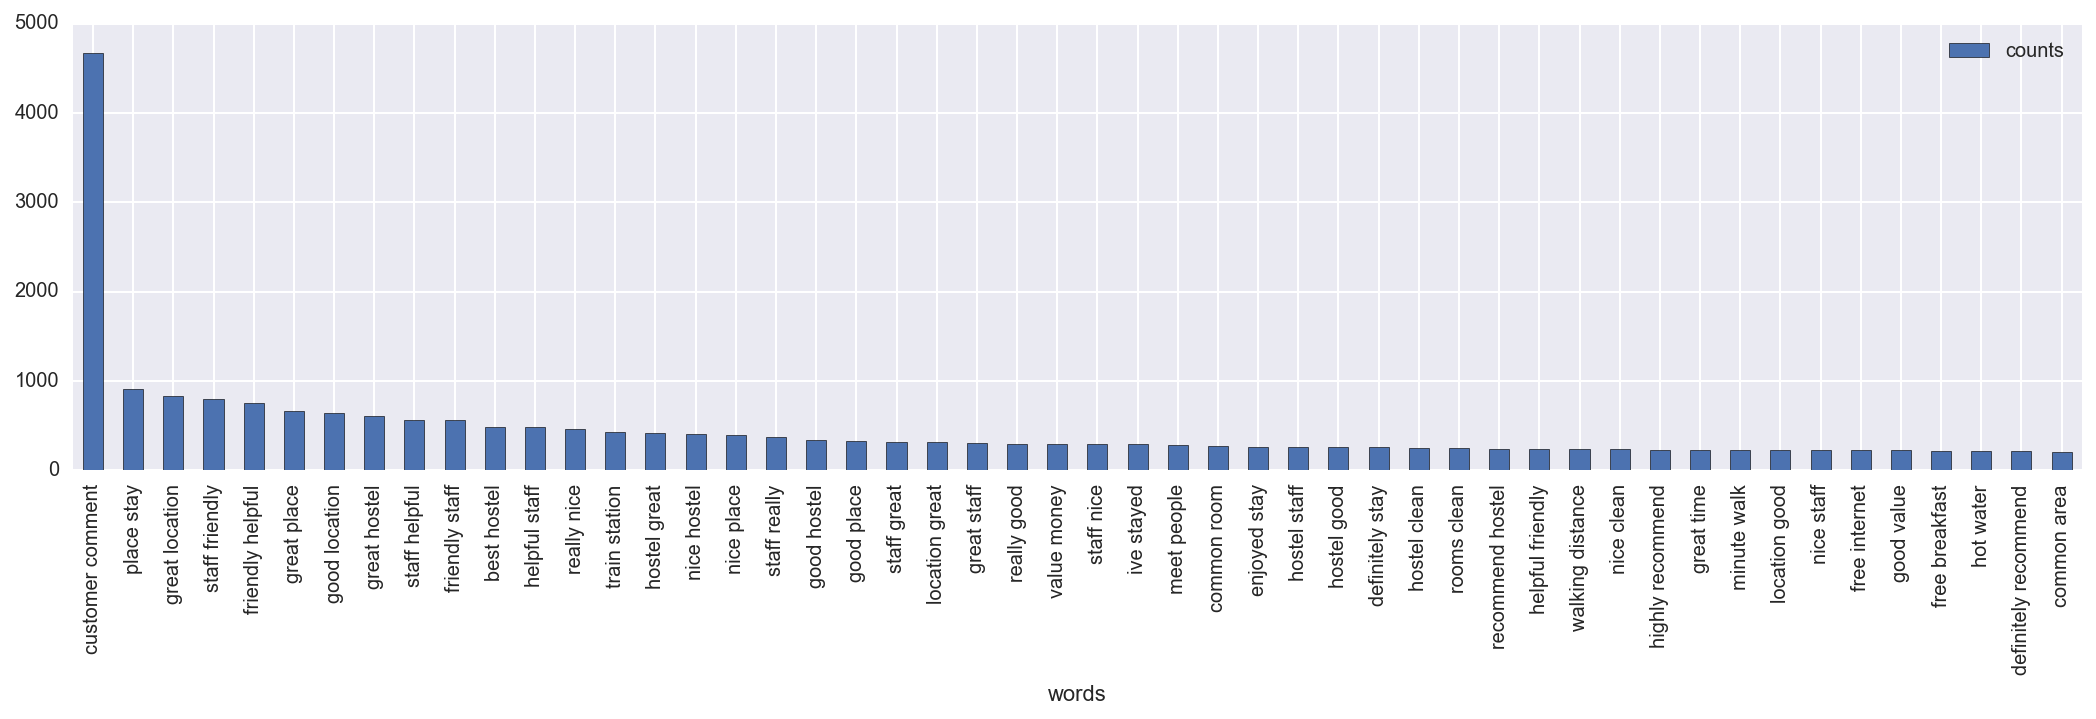

In [20]:
words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
word_count = words.sum(axis=0).reset_index()
word_count.columns = ['words','counts']
word_count.sort_values('counts', ascending=False, inplace=True)
word_count.head(50).plot(x='words', y='counts', kind='bar', figsize=(18,4))

# no customer comment is what is left when a user doesnt leave text in their reiview. 

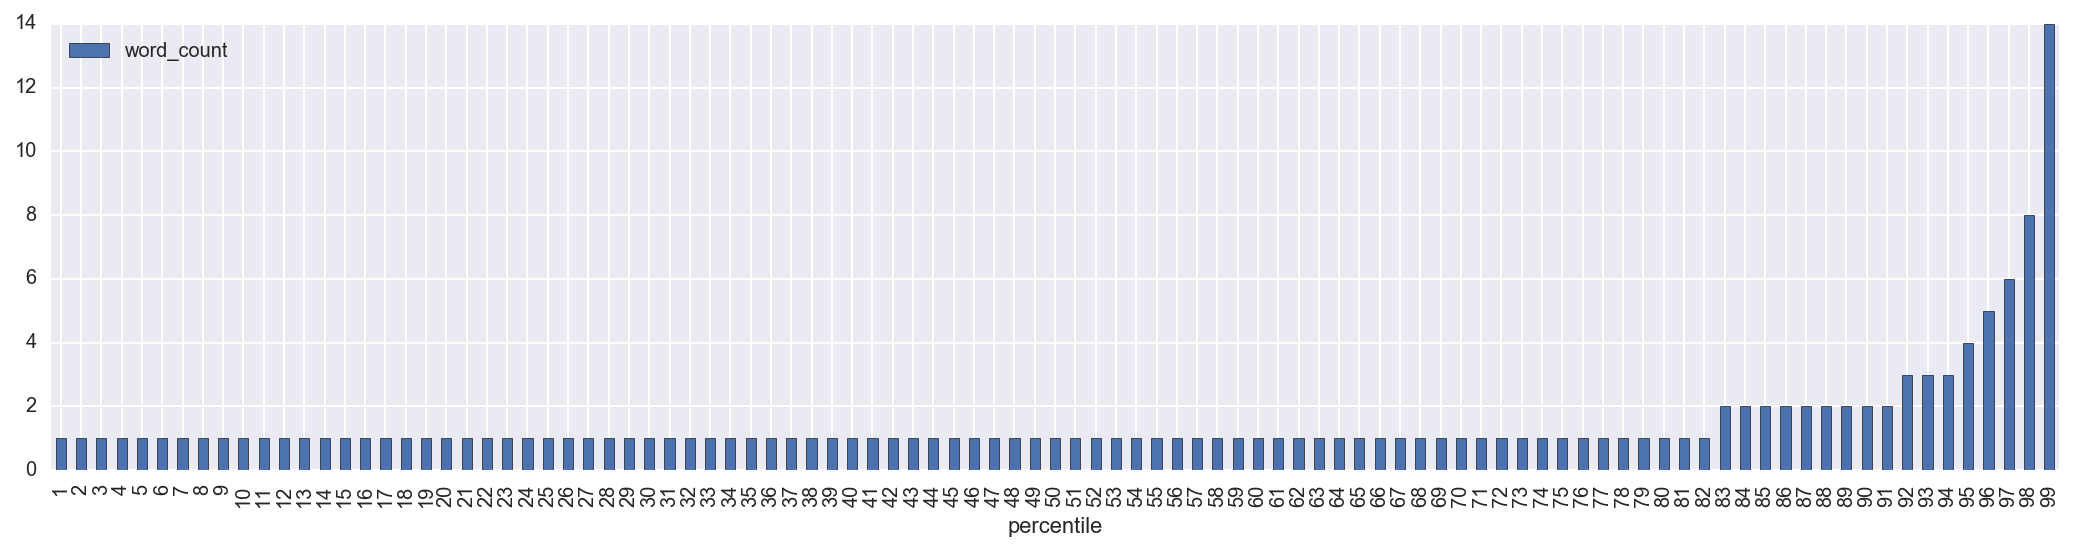

In [21]:
# look at what percentiles counts fall in 
# The counts of words are normally distributed

word_count_percentiles = pd.DataFrame({
        'percentile':np.arange(1,100,1),
        'word_count':np.percentile(word_count.counts, np.arange(1., 100., 1))
    })
word_count_percentiles.plot(x='percentile', y='word_count', kind='bar', figsize=(18,4))

## Use CountVectorizeer and LdaModel to create topics for hostel descriptions

In [22]:
# these are words I've decided to add to my stop words through a process of trial and error
stop_wrds = ['hostel','hostels','customer','ive','comment','nice','place','did','10','min', 'youre',
             'minutes','friendly','bit','minute','think','know','im','sure','great','temple','nights',
             'really','stayed','hotel','like','just','didnt','id','ok','stay','dont','ve','light','red',
             'wasnt','definitely','best','good','didn','don','staff', 'rooms', 'perfect']

# make a list my_stop_words with english stop words and new stop words
my_stop_words = text.ENGLISH_STOP_WORDS.union(stop_wrds)


In [23]:
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words=my_stop_words, min_df=.0, max_df=.7)

X = vectorizer.fit_transform(revs_df.text)
X.todense()

vocab = {v: k for k, v in vectorizer.vocabulary_.iteritems()}


In [ ]:
lda2 = models.LdaModel(
   matutils.Sparse2Corpus(X, documents_columns=False),
   num_topics  =  10,
   passes      =  25,
   iterations = 2500,
   id2word     =  vocab,
   eval_every = 100,
   chunksize = 500
)
lda2.print_topics(num_topics=10, num_words=5)

[(0,
  u'0.004*city center + 0.003*location helpful + 0.002*beds comfortable + 0.002*super clean + 0.002*clean breakfast'),
 (1,
  u'0.006*meet people + 0.003*helpful location + 0.003*easy meet + 0.002*common area + 0.001*small room'),
 (2,
  u'0.006*highly recommend + 0.002*dorm room + 0.002*free breakfast + 0.002*helpful clean + 0.002*location walk'),
 (3,
  u'0.005*room clean + 0.005*common area + 0.004*private room + 0.004*extremely helpful + 0.003*clean location'),
 (4,
  u'0.006*value money + 0.003*double room + 0.003*common areas + 0.002*hot showers + 0.002*room big'),
 (5,
  u'0.008*common room + 0.003*highly recommended + 0.002*bed dorm + 0.002*bar downstairs + 0.002*people staying'),
 (6,
  u'0.011*train station + 0.006*old town + 0.005*free breakfast + 0.005*walking distance + 0.004*location close'),
 (7,
  u'0.002*meet people + 0.002*super helpful + 0.002*clean helpful + 0.002*free wifi + 0.002*clean safe'),
 (8,
  u'0.003*location right + 0.002*location excellent + 0.002*r

In [ ]:
city center, location helpful, beds comfortable, super clean, clean breakfast 
meet people, helpful location, eady meet common area, small room
highly recommend, dorm room, free breakfast, helpful clean, location walk
room clean, common area, private room, eoremely helpful, clean location
value money, double room, common areas, hot showers, room big
common room, highly recommended, bed drom, bar downsrairs, people staying
train station, old town, free breakfast, walking distance, location close
meet people, super helpful, clean helpful, free wifi, clean safe
locaiton right, location excellend, room bathroom, clean room, short walk,
excellend location, hot water, bathrooms clean, breakfast included, room small

In [ ]:
bow = []
blank_documents = 0

for document in X.toarray():

    single_document = []

    for token_id, token_count in enumerate(document):
        
        if token_count > 0:
              single_document.append((token_id, token_count))
            
    if len(single_document)>0:
        bow.append(single_document)
    else:
        blank_documents += 1
        bow.append([])
        

In [ ]:
topic_proba =lda2.get_document_topics(bow)

### Put top prob into a dataframe

In [ ]:

topic_df = np.zeros((len(topic_proba),10))
for rowid, tp in enumerate(topic_proba):
    for colid, p in tp:
        topic_df[rowid, colid] = p
        
topic_df = pd.DataFrame(topic_df, columns=['Rt'+str(i+1) for i in range(topic_df.shape[1])])


In [68]:
topic_df.head()

,Rt1,Rt2,Rt3,Rt4,Rt5,Rt6,Rt7,Rt8,Rt9,Rt10
0,0.050000,0.050000,0.050000,0.050000,0.050000,0.550000,0.050000,0.050000,0.050000,0.050000
1,0.080499,0.638733,0.000000,0.000000,0.000000,0.000000,0.000000,0.160186,0.080581,0.000000
2,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
3,0.020001,0.020001,0.819992,0.020001,0.020001,0.020001,0.020001,0.020001,0.020001,0.020001
4,0.000000,0.000000,0.000000,0.882884,0.000000,0.000000,0.000000,0.000000,0.087484,0.000000


In [69]:
# create new columns to topic porb dataframe for max topic probabitlity for each review

columns = topic_df.columns
topic_df['max_prob'] =  topic_df[columns].apply(np.max, axis=1)


In [70]:
topic_df['max_prob'].describe()


count    21675.000000
mean         0.567158
std          0.297881
min          0.100000
25%          0.220002
50%          0.679396
75%          0.809077
max          0.988312
Name: max_prob, dtype: float64

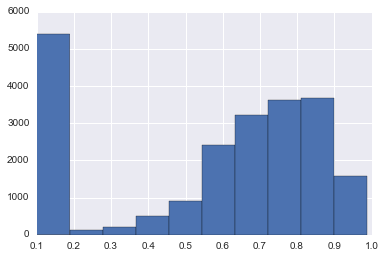

In [71]:
# hist of max topic prob for revs_df
# want max topic prob to be on the high side 
topic_df['max_prob'].hist()


In [72]:
# are ther any reviews that have no topic prob? 
topic_df[topic_df['max_prob']==0]


,Rt1,Rt2,Rt3,Rt4,Rt5,Rt6,Rt7,Rt8,Rt9,Rt10,max_prob


### Create a New DF for calculating Users Distance 
- take relevant rev info and combine with topic prob
- group by user id and take mean of topic probs and scores
- creat a df for every users hostel lists 

In [73]:
revs_df.columns


Index([u'Unnamed: 0', u'text', u'user_id', u'rev_date', u'score', u'hostel',
       u'location', u'link', u'country', u'city', u'day', u'month', u'year',
       u'country_id', u'hostel_id'],
      dtype='object')

In [74]:
rel_revs = revs_df[['user_id','hostel_id','score','day','month','year','country_id']]


In [75]:
rel_revs.head()

,user_id,hostel_id,score,day,month,year,country_id
0,1189474,0,7.7,30,6,2004,28.0
1,1595059,1,7.7,23,12,2004,5.0
2,3637809,2,10.0,4,10,2012,49.0
3,3835945,3,6.3,29,3,2007,46.0
4,3461306,4,4.7,27,4,2007,5.0


In [76]:
rel_revs.shape,topic_df.shape

((21675, 7), (21675, 11))

In [77]:
result = pd.concat([rel_revs, topic_df], axis=1)

del result['max_prob']

result.shape

(21675, 17)

In [80]:
result.head()

,user_id,hostel_id,score,day,month,year,country_id,Rt1,Rt2,Rt3,Rt4,Rt5,Rt6,Rt7,Rt8,Rt9,Rt10
0,1189474,0,7.7,30,6,2004,28.0,0.050000,0.050000,0.050000,0.050000,0.050000,0.550000,0.050000,0.050000,0.050000,0.050000
1,1595059,1,7.7,23,12,2004,5.0,0.080499,0.638733,0.000000,0.000000,0.000000,0.000000,0.000000,0.160186,0.080581,0.000000
2,3637809,2,10.0,4,10,2012,49.0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
3,3835945,3,6.3,29,3,2007,46.0,0.020001,0.020001,0.819992,0.020001,0.020001,0.020001,0.020001,0.020001,0.020001,0.020001
4,3461306,4,4.7,27,4,2007,5.0,0.000000,0.000000,0.000000,0.882884,0.000000,0.000000,0.000000,0.000000,0.087484,0.000000


In [2]:
user_topics = result.groupby(['user_id'])[['score','Rt1','Rt2','Rt3','Rt4','Rt5','Rt6','Rt7','Rt8','Rt9','Rt10']].mean()

NameError: name 'result' is not defined

In [147]:
user_topics.shape
user_topics = user_topics.reindex()

In [148]:
hostels_lst = []
userids = []
for i in revs_df.user_id.unique():
    hsts = []
    for h in revs_df['hostel_id'][revs_df['user_id'] == i]:
        hsts.append(h)
    userids.append(i)
    hostels_lst.append(list(hsts))

In [149]:
len(hostels_lst), len(userids)

(10929, 10929)

In [150]:
user_hostels = pd.DataFrame()
user_hostels['user_id'] = userids
user_hostels['hostel_lst'] = hostels_lst
user_hostels['num_hostels'] = [len(h) for h in hostels_lst]

In [151]:
user_hostels.shape

(10929, 3)

In [152]:
user_hostels.head(2)

,user_id,hostel_lst,num_hostels
0,1189474,[0],1
1,1595059,[1],1


In [154]:
user_topics = user_topics.reset_index()

In [156]:
user_topics.head(2)

,user_id,score,Rt1,Rt2,Rt3,Rt4,Rt5,Rt6,Rt7,Rt8,Rt9,Rt10
0,1004454,8.3,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112,0.899995,0.011112,0.011112
1,1004711,8.9,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.550000,0.050000,0.050000


In [160]:
user_topics.shape

(10929, 12)

In [157]:
user_rev_df = pd.merge(user_topics, user_hostels, on='user_id')
# pd.merge(df_new, df_n, on='subject_id')
user_rev_df.shape

(10929, 14)

In [159]:
user_rev_df.head()

,user_id,score,Rt1,Rt2,Rt3,Rt4,Rt5,Rt6,Rt7,Rt8,Rt9,Rt10,hostel_lst,num_hostels
0,1004454,8.3,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112,0.899995,0.011112,0.011112,[99],1
1,1004711,8.9,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.550000,0.050000,0.050000,[2695],1
2,1005901,9.0,0.012500,0.012500,0.012500,0.138934,0.012500,0.761065,0.012500,0.012500,0.012500,0.012500,[227],1
3,1007654,9.0,0.010000,0.010000,0.010000,0.481875,0.010000,0.119279,0.010000,0.300718,0.010000,0.010000,"[780, 780]",2
4,1019748,4.0,0.000000,0.000000,0.935714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,[2967],1


In [161]:
del user_rev_df['hostel_lst']

In [162]:
user_rev_df.to_csv(path_or_buf='/Users/caitlinmowdy/Desktop/DSI-SF-2-caitlinmowdy/capstone-hostelworld/clean-data/users_4dist_oct7.csv',encoding='utf8')

In [163]:
hostelidsdf = pd.read_csv('/Users/caitlinmowdy/Desktop/DSI-SF-2-caitlinmowdy/capstone-hostelworld/clean-data/hostles_ids_oct7.csv')
hostelidsdf.head(2)

,Unnamed: 0,hostel_id,hostel
0,0,0,Fortuna Botel
1,1,1,Equity Point Sea


In [169]:
def get_hst_name(hst_id):
    return list(hostelidsdf['hostel'] [hostelidsdf['hostel_id'] == hst_id])[0]

In [170]:
hst_names = []
for i,l in enumerate(user_hostels.hostel_lst):
    hst_name_lst = []
    for h in user_hostels.hostel_lst[i]:
        hst_name_lst.append(get_hst_name(h))
    hst_names.append(hst_name_lst)

In [172]:
len(hst_names)

10929

In [173]:
user_hostels['hst_names_lst'] = hst_names

In [174]:
user_hostels.head(10)

,user_id,hostel_lst,num_hostels,hst_names_lst
0,1189474,[0],1,[Fortuna Botel]
1,1595059,[1],1,[Equity Point Sea]
2,3637809,[2],1,[The Naughty Squirrel Backpackers Hostel]
3,3835945,[3],1,[La Chimba Hostel]
4,3461306,[4],1,[Barcelona 4 Fun Hostel]
5,3298399,"[5, 6, 7, 6]",4,"[Bed & Bike Barcelona, B&B Giovy, CroParadise ..."
6,4689406,[8],1,[Le Montclair Montmartre Hostel & Budget Hotel]
7,2654918,"[9, 10, 11, 12, 13, 14, 15]",7,"[India House Backpackers Hostel, HI Austin, Sl..."
8,1892703,"[16, 17]",2,"[Budget Backpackers, Aviemore Youth Hostel]"
9,3986679,[18],1,[Bong House]


In [175]:
user_hostels.to_csv(path_or_buf='/Users/caitlinmowdy/Desktop/DSI-SF-2-caitlinmowdy/capstone-hostelworld/clean-data/user_hostels_info_oct7.csv',encoding='utf8')

In [176]:
users_df = pd.read_csv('/Users/caitlinmowdy/Desktop/DSI-SF-2-caitlinmowdy/capstone-hostelworld/clean-data/clean_users_oct7.csv')

In [177]:
users_df.head()

,Unnamed: 0,user_id,num_revs,nationality,group,age,country_id
0,0,1189474,2,England,NaN,not specified,0
1,1,1595059,2,Hong Kong,NaN,not specified,1
2,2,3637809,1,Australia,Male,31-40,2
3,3,3835945,1,England,NaN,not specified,0
4,4,3461306,3,Canada,NaN,not specified,3


In [193]:
group_ids = pd.DataFrame(list(users_df.group.unique()))
group_ids = group_ids.reset_index()
group_ids.columns = ['group_id','group_type']

group_ids.head(2)

,group_id,group_type
0,0,NaN
1,1,Male


In [226]:
# def to change group types to group ids 
lst = list(users_df.group.unique())[1:]
def get_grp_id(value):
    if value in lst:
        return int(group_ids['group_id'][group_ids['group_type']==value].values)
    else:
        return 0
    
users_df['group_id'] = users_df['group'].map(get_grp_id)

users_df.head()

,Unnamed: 0,user_id,num_revs,nationality,group,age,country_id,group_id
0,0,1189474,2,England,NaN,not specified,0,0
1,1,1595059,2,Hong Kong,NaN,not specified,1,0
2,2,3637809,1,Australia,Male,31-40,2,1
3,3,3835945,1,England,NaN,not specified,0,0
4,4,3461306,3,Canada,NaN,not specified,3,0


In [227]:
age_ids = pd.DataFrame(list(users_df.age.unique()))
age_ids = age_ids.reset_index()
age_ids.columns = ['age_id','age_group']

age_ids.head(2)

,age_id,age_group
0,0,not specified
1,1,31-40


In [228]:
def get_age_id(value):
    return int(age_ids['age_id'][age_ids['age_group']==value].values)

    
users_df['age_id'] = users_df['age'].map(get_age_id)

users_df.head()

,Unnamed: 0,user_id,num_revs,nationality,group,age,country_id,group_id,age_id
0,0,1189474,2,England,NaN,not specified,0,0,0
1,1,1595059,2,Hong Kong,NaN,not specified,1,0,0
2,2,3637809,1,Australia,Male,31-40,2,1,1
3,3,3835945,1,England,NaN,not specified,0,0,0
4,4,3461306,3,Canada,NaN,not specified,3,0,0


In [231]:
users_info = users_df[['user_id','num_revs','country_id','group_id','age_id']]

In [232]:
user_info_rev_df = pd.merge(user_rev_df, users_info, on='user_id')

In [233]:
user_info_rev_df.head()

,user_id,score,Rt1,Rt2,Rt3,Rt4,Rt5,Rt6,Rt7,Rt8,Rt9,Rt10,num_hostels,num_revs,country_id,group_id,age_id
0,1004454,8.3,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112,0.899995,0.011112,0.011112,1,1,3,0,0
1,1004711,8.9,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.550000,0.050000,0.050000,1,1,10,6,1
2,1005901,9.0,0.012500,0.012500,0.012500,0.138934,0.012500,0.761065,0.012500,0.012500,0.012500,0.012500,1,2,45,0,0
3,1007654,9.0,0.010000,0.010000,0.010000,0.481875,0.010000,0.119279,0.010000,0.300718,0.010000,0.010000,2,2,21,3,2
4,1019748,4.0,0.000000,0.000000,0.935714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,0,0,0


In [234]:
user_info_rev_df.to_csv(path_or_buf='/Users/caitlinmowdy/Desktop/DSI-SF-2-caitlinmowdy/capstone-hostelworld/clean-data/user_rev_info_4dist_oct7.csv',encoding='utf8')

In [4]:
user_info = pd.read_csv('/Users/caitlinmowdy/Desktop/DSI-SF-2-caitlinmowdy/capstone-hostelworld/clean-data/user_rev_info_4dist_oct7.csv')
del user_info['Unnamed: 0']

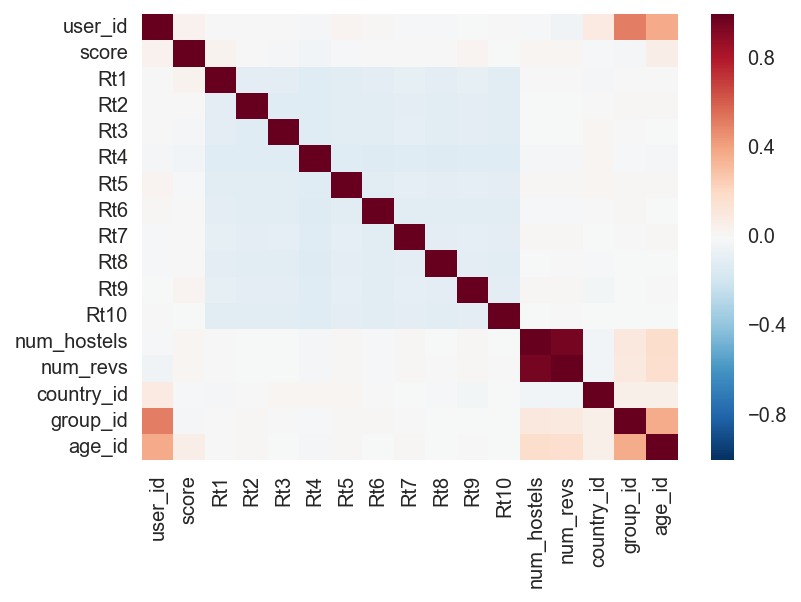

In [5]:
cor = user_info.corr()
sns.heatmap(cor)